In [296]:
import javalang
import tensorflow as tf
import numpy as np
from keras.layers import Dropout, Dense, Input, Concatenate, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [297]:
dataset = pd.read_csv("../dataset/dataset_v2.csv")

def tokenize_and_normalize(source_code):
    tokens = list(javalang.tokenizer.tokenize(source_code))
    normalized_tokens = []
    for token in tokens:
        if isinstance(token, javalang.tokenizer.Identifier):
            normalized_tokens.append("IDENT")
        elif isinstance(token, javalang.tokenizer.String):
            normalized_tokens.append("STRING")
        elif isinstance(token, javalang.tokenizer.Integer):
            normalized_tokens.append("INT")
        elif isinstance(token, javalang.tokenizer.FloatingPoint):
            normalized_tokens.append("FLOAT")
        else:
            normalized_tokens.append(token.value)
    return normalized_tokens

# Collect all unique token types
all_tokens = []
for _, row in dataset.iterrows():
    code1 = row.iloc[0]
    code2 = row.iloc[1]
    all_tokens.extend(tokenize_and_normalize(code1))
    all_tokens.extend(tokenize_and_normalize(code2))
token_types = sorted(list(set(all_tokens)))
token_type_to_idx = {tok: i for i, tok in enumerate(token_types)}

# Function to build Markov transition matrix
def build_markov_matrix(tokens, token_type_to_idx):
    n = len(token_type_to_idx)
    matrix = np.zeros((n, n), dtype=np.float32)
    for i in range(len(tokens) - 1):
        idx_from = token_type_to_idx[tokens[i]]
        idx_to = token_type_to_idx[tokens[i+1]]
        matrix[idx_from, idx_to] += 1
    # Normalize rows to sum to 1 (if row sum > 0)
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix = np.divide(matrix, row_sums, out=np.zeros_like(matrix), where=row_sums!=0)
    return matrix

In [298]:
def preprocess_pair_markov(code1, code2, token_type_to_idx):
    tokens_1 = tokenize_and_normalize(code1)
    tokens_2 = tokenize_and_normalize(code2)
    mat_1 = build_markov_matrix(tokens_1, token_type_to_idx)
    mat_2 = build_markov_matrix(tokens_2, token_type_to_idx)
    return mat_1, mat_2

In [299]:
seq_1_list, seq_2_list, labels = [], [], []
for _, row in dataset.iterrows():
    code1 = row.iloc[0]
    code2 = row.iloc[1]
    mat1, mat2 = preprocess_pair_markov(code1, code2, token_type_to_idx)
    seq_1_list.append(mat1)
    seq_2_list.append(mat2)
    labels.append(row.iloc[2])

X1 = np.stack(seq_1_list)
X2 = np.stack(seq_2_list)
labels = np.array(labels)

# Reshape for Conv2D: (samples, height, width, channels)
X1 = X1[..., np.newaxis]
X2 = X2[..., np.newaxis]

X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(
    X1, X2, labels, test_size=0.2, random_state=127
)

In [300]:
from keras.regularizers import l2

input_shape = X1.shape[1:]  # (height, width, 1)

input_1 = Input(shape=input_shape)
input_2 = Input(shape=input_shape)

def build_conv_encoder():
    model = Sequential([
        Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Flatten(),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3)
    ])
    return model

encoder_model = build_conv_encoder()

encoded_1 = encoder_model(input_1)
encoded_2 = encoder_model(input_2)

merged = Concatenate()([encoded_1, encoded_2])
output = Dense(1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[input_1, input_2], outputs=output)
siamese_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

/home/printchard/workspace/tc3002b/Code-Plagiarism-Detection/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [301]:
from keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model
history = siamese_model.fit(
    [X_train_1, X_train_2], y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    # callbacks=[early_stopping]
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7694 - loss: 0.5393 - val_accuracy: 0.9286 - val_loss: 0.3367
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9239 - loss: 0.3380 - val_accuracy: 0.9196 - val_loss: 0.3307
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9268 - loss: 0.2968 - val_accuracy: 0.9286 - val_loss: 0.3427
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9487 - loss: 0.2464 - val_accuracy: 0.9286 - val_loss: 0.3422
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9320 - loss: 0.2606 - val_accuracy: 0.9196 - val_loss: 0.3475
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9498 - loss: 0.2530 - val_accuracy: 0.9018 - val_loss: 0.3622
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9202 - loss: 0.2693 - val_accuracy: 0.9464 - val_loss: 0.3515
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9536 - loss: 0.2108 - val_accuracy: 0.9286 - v

In [ ]:
test_similarity = siamese_model.predict([X_test_1, X_test_2])

threshold = 0.45
pred_labels = (test_similarity.flatten() > threshold).astype(int)
accuracy = np.mean(pred_labels == y_test)
print(f"Test set accuracy (threshold={threshold}): {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test set accuracy (threshold=0.25): 0.8741


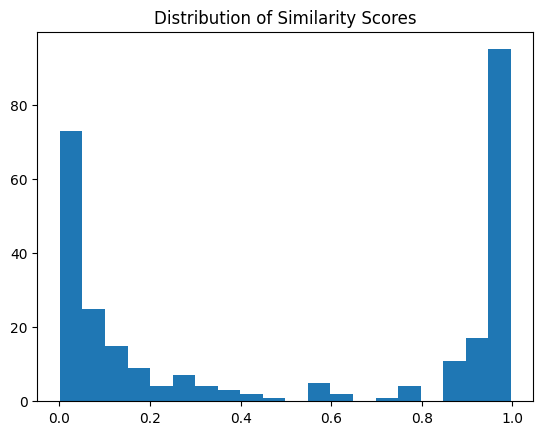

In [339]:
plt.hist(test_similarity.flatten(), bins=20)
plt.title("Distribution of Similarity Scores")
plt.show()

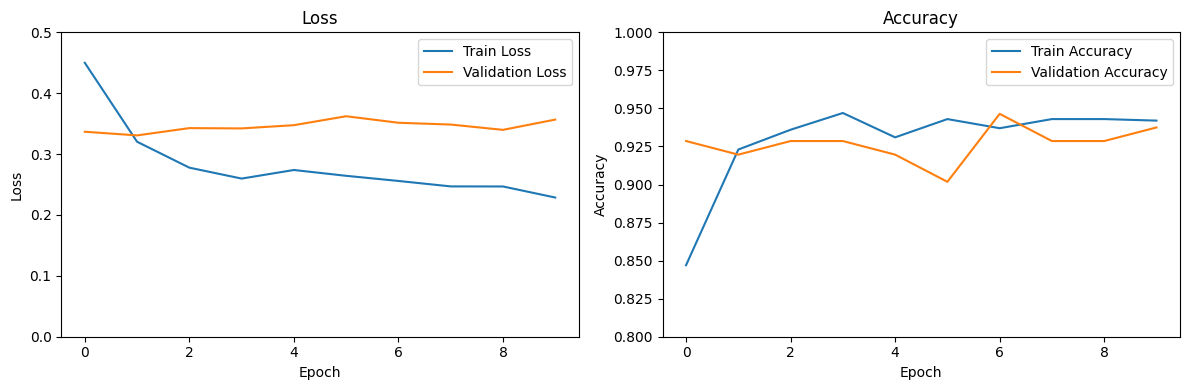

In [340]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12, 4))

# Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_ylim((0, 0.5))
ax1.set_title('Loss')

# Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_ylim((0.8, 1))
ax2.set_title('Accuracy')

plt.tight_layout()
plt.show()

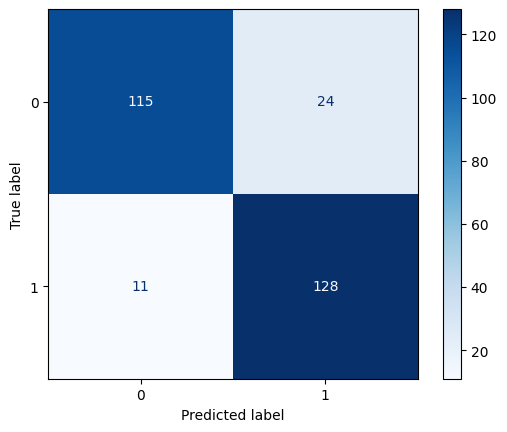

In [341]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [342]:
from sklearn.metrics import f1_score, recall_score, precision_score

recall = recall_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Recall: 0.9209
Precision: 0.8421
F1 Score: 0.8797


In [343]:
siamese_model.save_weights("siamese_model.weights.h5")